# Check Biharmonic

In [83]:
#imports
import os
import numpy as np

import h5py

from matplotlib import pyplot as plt

from ulmo import plotting
from ulmo import io as ulmo_io
from ulmo.utils import image_utils

from enki import utils
from enki import patch_analysis
from enki import plotting as enki_plotting
from enki.cutout_analysis import rms_images, simple_inpaint

In [4]:
sst_path = os.getenv('OS_SST')
ogcm_path = os.getenv('OS_OGCM')
enki_path = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Enki')

valid_tbl_file = os.path.join(enki_path, 'Tables',
                              'Enki_LLC_valid_nonoise.parquet')
valid_img_file = os.path.join(enki_path, 'PreProc',
                              'Enki_LLC_valid_nonoise_preproc.h5')

# Load

In [5]:
t=20
p=30

In [6]:
# Files
local_enki_table = os.path.join(
    enki_path, 'Tables', 
    'Enki_LLC_valid_nonoise.parquet')
local_mae_valid_nonoise_file = os.path.join(
    enki_path, 'PreProc', 
    'Enki_LLC_valid_nonoise_preproc.h5')
local_orig_file = local_mae_valid_nonoise_file
inpaint_file = os.path.join(
    ogcm_path, 'LLC', 'Enki', 
    'Recon', f'Enki_LLC2_nonoise_biharmonic_t{t}_p{p}.h5')
recon_file = utils.img_filename(t,p, local=True, dataset='LLC2_nonoise')
mask_file = utils.mask_filename(t,p, local=True, dataset='LLC2_nonoise')

# Load up
enki_tbl = ulmo_io.load_main_table(local_enki_table)
f_orig = h5py.File(local_orig_file, 'r')
f_recon = h5py.File(recon_file, 'r')
f_inpaint = h5py.File(inpaint_file, 'r')
f_mask = h5py.File(mask_file, 'r')

Read main table: /home/xavier/Projects/Oceanography/OGCM/LLC/Enki/Tables/Enki_LLC_valid_nonoise.parquet


In [18]:
inpaint_file

'/home/xavier/Projects/Oceanography/OGCM/LLC/Enki/Recon/Enki_LLC2_nonoise_biharmonic_t20_p30.h5'

# Calculate

In [8]:
nimgs = 50000

# Calculate
rms_enki = rms_images(f_orig, f_recon, f_mask, nimgs=nimgs)
rms_inpaint = rms_images(f_orig, f_inpaint, f_mask, nimgs=nimgs,
                         keys=['valid', 'inpainted', 'valid'])

Loading images...
Masking edges
Calculate
Square
Mean
Root
Loading images...
Masking edges
Calculate
Square
Mean
Root


# Focus on a few at 0.05

In [9]:
near_005 = np.abs(rms_enki - 0.05) < 0.005
np.sum(near_005)

1690

In [67]:
idx = np.where(near_005)[0][10]

## Grab the images

In [68]:
orig = f_orig['valid'][idx,0,...]
recon = f_recon['valid'][idx,0,...]
biharm = f_inpaint['inpainted'][idx, ...]
mask = f_mask['valid'][idx,0,...]

In [69]:
orig.shape

(64, 64)

In [70]:
biharm.shape

(64, 64)

## Compare

<Axes: >

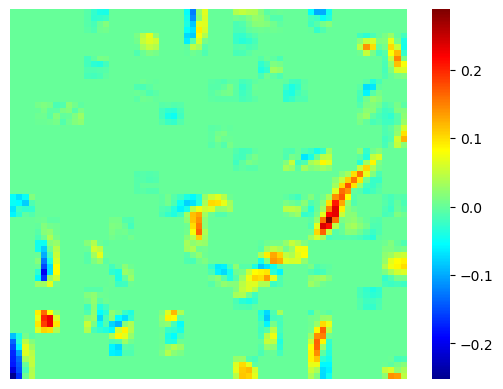

In [71]:
plotting.show_image(recon-orig)

In [72]:
np.std(recon-orig)

0.02872388

In [73]:
diff = recon-orig
keep = mask == 1
np.std(diff[keep])

0.051784806

In [74]:
rms_enki[idx]

0.05115548

In [75]:
np.sum(mask)

1232.0

<Axes: >

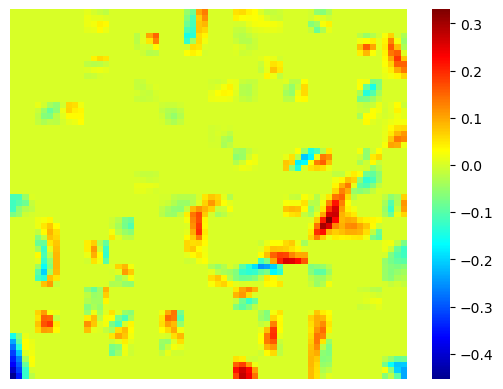

In [76]:
plotting.show_image(biharm-orig)

In [77]:
diff2 = biharm-orig
np.std(diff2[keep])

0.07907868

# Correct this one

In [78]:
items = [orig, mask, idx]

In [79]:
biharm2,_ = simple_inpaint(items)

<Axes: >

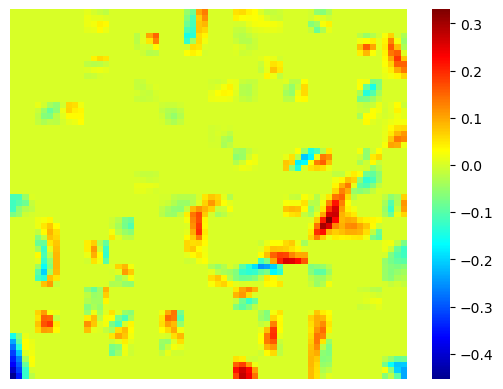

In [80]:
plotting.show_image(biharm2-orig)

In [81]:
diff3 = biharm2-orig
np.std(diff3[keep])

0.07907868

----

<Axes: >

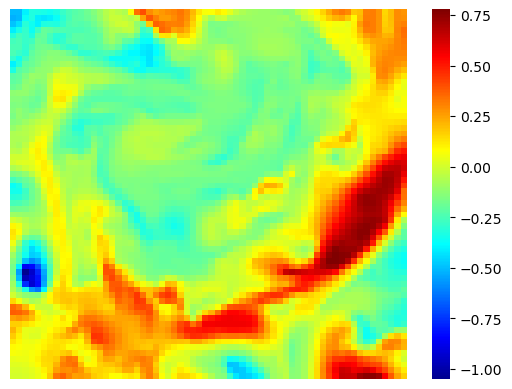

In [82]:
plotting.show_image(biharm)

In [29]:
biharm.shape

(64,)

----

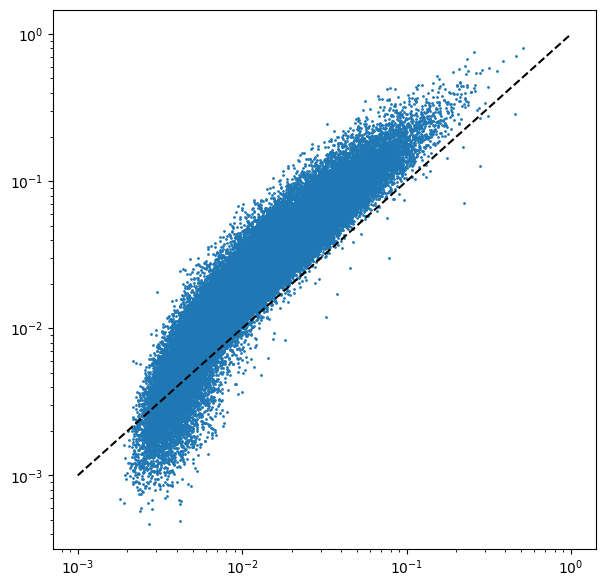

In [89]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()

ax.scatter(rms_enki, rms_inpaint, s=1)

ax.plot([1e-3, 1], [1e-3, 1], 'k--')

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()